In [1]:
%matplotlib inline
import make_discrete_vdf as mdv
import numpy as np
import matplotlib.pyplot as plt
from fancy_plot import fancy_plot
from multiprocessing import Pool
import time
from scipy.optimize import curve_fit
import multi_fc_functions as mff
from scipy.interpolate import RectBivariateSpline
import geo_dist as gd



In [2]:
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [3]:
#set up plasma parameters
#                    Vx  ,  Vy,  Vz ,Wper,Wpar, Np
#pls_par = np.array([-380., -30., 30., 20., 40., 5.]) 
pls_par = np.array([-580., 10., -10., 20., 20., 15.]) 
#pls_par = np.array([-480., -100., -80., 20., 50., 25.])
#pls_par = np.array([-380., -100., 50., 30., 10., 50.]) 
#pls_par = np.array([-880., 100.,-150., 30., 10., 5.]) 
#mag_par = np.array([np.cos(np.radians(75.))*np.cos(.1), np.sin(np.radians(75.))*np.cos(.1), np.sin(.1)]) 
#mag_par = np.array([-np.cos(np.radians(25.)),np.sin(np.radians(25.)), 0.]) 
mag_par = np.array([-1.,0., 0.])

#Set up observering condidtions before making any VDFs
#veloity grid
#########################################
######################################
#grid_v = np.arange(450,790,15
v_mag = np.sqrt(np.sum(pls_par**2))
grid_v = np.arange(v_mag-150,v_mag+150,15)
#get effective area of wind and other coversion parameters
waeff = 3.8e6 #cm^3/km
q0    = 1.6021892e-7 # picocoulombs
dv    = np.diff(grid_v)
dv    = np.concatenate([dv,[dv[-1]]])
cont  = 1.e12/(waeff*q0*dv*grid_v)

In [4]:
#Changed to mean km/s in p,q space 2018/10/19
samp = 1.5e1
#make a discrete VDF
#updated clip to a velocity width 2018/10/12 J. Prchlik
#Set to a "Total velocity width" which could be measured by the space craft 2018/10/15
vel_clip = 8.*np.sqrt(np.sum(pls_par[4:6]**2))
dis_vdf = mdv.make_discrete_vdf(pls_par,mag_par,pres=1.00,qres=1.00,clip=vel_clip)
normval = np.ones(dis_vdf['pgrid'].shape)
normval /= np.sum(normval)

#Add a positive Gaussian Kernal to "Measured" VDF
dis_vdf['vdf'] += dis_vdf['vdf'].max()*np.exp(- ((dis_vdf['pgrid']-(-100))/10)**2. - ((dis_vdf['qgrid']-(0))/5)**2.)
#update the interpolator function
dis_vdf['vdf_func'] =  RectBivariateSpline(dis_vdf['pgrid'][:,0],dis_vdf['qgrid'][0,:],dis_vdf['vdf'])
                         

#get random angles of faraday cup in phi and theta
#number of fc cups
ncup = 20
#set random seed for FC angles
#np.random.seed(1107)


#Get two uniform number between -30 and 30
limit = 90.
phis = np.random.uniform(-limit,limit,size=ncup)
thetas = np.random.uniform(-30.,30.,size=ncup)


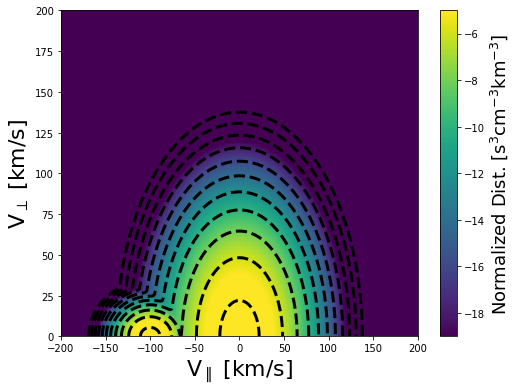

In [5]:
#"REAL" OBSERVATION
mdv.plot_vdf(dis_vdf)
plt.show()

In [6]:

#array that store all the fit parameters 
big_arr = []
#calculate the "real measured reduced response function" for all fc cups
fcs = {}
for k,(phi,theta) in enumerate(zip(phis,thetas)):
    #calculate x_meas array
    x_meas = mdv.make_fc_meas(dis_vdf,fc_spd=grid_v,fc_phi=phi,fc_theta=theta)
    #compute the observed current in the instrument
    #Use dynamic sampling 2018/10/12 J. Prchlik
    #rea_cur = mdv.arb_p_response(x_meas,dis_vdf,samp)
    rad_phi,rad_theta = np.radians((phi,theta))
    pro_unt = np.array([np.cos(rad_phi)*np.cos(rad_theta),np.sin(rad_phi)*np.cos(rad_theta),np.sin(rad_theta)])
    peak = np.abs(pls_par[:3].dot(pro_unt))
    #here sampling is in km/s
    rea_cur = mdv.arb_p_response(x_meas,dis_vdf,samp)
    #switched back to static sampling but now using p',q',r' for sampling
    #rea_cur = mdv.arb_p_response_dyn_samp(x_meas,dis_vdf,peak)

    #create key for input fc
    key = 'fc_{0:1d}'.format(k)
    fcs[key] = {}

    #populate key with measurements and parameter 
    fcs[key]['x_meas']  = x_meas
    fcs[key]['rea_cur'] = rea_cur
    fcs[key]['peak']    = peak


    #calculate the Gaussian fit of the response
    try:
        popt, pcov = curve_fit(gaus,grid_v,rea_cur*cont,p0=[np.nanmax(rea_cur*cont),np.mean(grid_v),np.sqrt(2.)*2*dv[0]],sigma=1./(rea_cur/rea_cur.min()),maxfev=5000)
    except RuntimeError:
        #give number that will be thrown out if no fit is found 
        popt = np.zeros(3)-9999.9
        pcov = np.zeros((3,3))-9999.9


    #Switched to computing the average
    #####get the parameters from the fit
    u = popt[1] #speed in km/s
    w = np.abs(popt[2]*np.sqrt(2.)) #thermal speed in km/s
    n = popt[0]*w*np.sqrt(np.pi) #density in cc
    ####
    #####uncertainty in parameters from fit
    du = np.sqrt(pcov[1,1])
    dw = np.sqrt(pcov[2,2])
    dn = np.sqrt(np.pi*((w**2.*pcov[0,0]) + (dw*n)**2))


    #Add fit parameters with velocity guesses
    big_arr.append([u,w,n,phi,theta,du,dw,dn])


#convert big_arr intop numpy array
big_arr = np.array(big_arr)

/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in sqrt
/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in sqrt


In [7]:
#get speed solution per observatory
v_angl = big_arr[:,0]
uv_angl = big_arr[:,5]
#thermal speed in GSE
w_angl = big_arr[:,1]
uw_angl = big_arr[:,6]
#get the density to compute the magnitude
n_angl = big_arr[:,2]
un_angl = big_arr[:,7]



#Number of processors to use when parallel processing
nproc = 8




In [8]:
#Use the top 5 peaks to get density and velocity values if the number of measurements are greater than 5
top5 = n_angl > np.sort(n_angl)[-6]

#get v_gse solution (Produces the same solution as the Wind spacecraft solution)
#in /crater/observatories/wind/code/dvapbimax/sub_bimax_moments.pro
v_vec =  mdv.compute_gse_from_fit(np.radians(phis[top5]),np.radians(thetas[top5]),-v_angl[top5]) #np.dot(np.dot(np.dot(v_svdc.T,wp_svdc),u_svdc.T),v_angl)
vx,vy,vz = v_vec


In [9]:
#Get Wper and Wpar vectors using SVD and the magnetic field vectors
wv_par =  mdv.compute_gse_from_fit(np.radians(phis[top5]),np.radians(thetas[top5]),w_angl[top5])
wa = np.abs(wv_par.dot(mag_par))
we = np.sqrt(np.linalg.norm(wv_par)**2.-wv_par.dot(mag_par)**2.)



In [10]:
#compute angle between FC and the observed bulk velocity (cos(theta`))
n = np.median(np.abs(n_angl[top5]))

In [11]:
#dont let initial guess be smaller than half a bin size
if we < min(dv)/2.:
    we = min(dv)/2.


#make a discrete VDF with the incorrect parameters but the same grid
pls_par_bad = np.array([vx, vy, vz,we,wa,n])




In [12]:

######################################################################
######################################################################
#EVERYTHING BEFORE THIS WOULD BE MEASURED BY A SPACECRAFT
######################################################################
######################################################################

#Updated with vel_clip parameter 2108/10/12 J. Prchlik
dis_vdf_bad = mdv.make_discrete_vdf(pls_par_bad,mag_par,pres=1.00,qres=1.00,clip=vel_clip)
#store the initial bad guess 
dis_vdf_bad_guess = dis_vdf_bad
dis_vdf_bad = dis_vdf_bad_guess

In [13]:
#Get the initial distribution based on input parameters 2018/09/19 J. Prchlik 
for k,i in enumerate(fcs.keys()):
    i = 'fc_{0:1d}'.format(k)
    #updated using dynamic sampling 2018/10/12 J. Prchlik
    fcs[i]['init_guess'] = mdv.arb_p_response(fcs[i]['x_meas'],dis_vdf_bad_guess,samp)






In [14]:
#######Give info on best fit versus real solution######
print(pls_par)
print(pls_par_bad)

[-580.   10.  -10.   20.   20.   15.]
[-579.87443603    9.79686008   -9.16922078    7.5          21.83050034
   13.10604325]


In [15]:
#Updated MC guess based on poor judgement of perpendicular velocity component
pgrid = np.abs(dis_vdf_bad_guess['pgrid'].ravel())
qgrid = np.abs(dis_vdf_bad_guess['qgrid'].ravel())

dis = np.zeros(pgrid.size)
for i,(x,y) in enumerate(zip(pgrid,qgrid)):
    dis[i] = gd.distance_point_ellipse(wa,we,x,y)
    
dist = dis.reshape(dis_vdf_bad_guess['pgrid'].shape)

/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


3.06332344104e-85


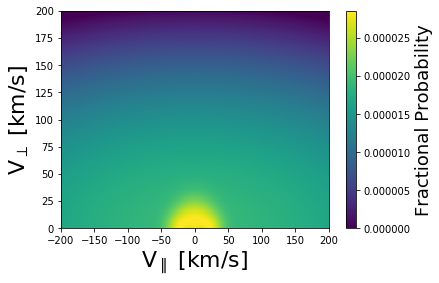

In [16]:
#Guess width
g_wid = 20 #km/s

#Initial guess around current guess of 2d VDF
pred_grid = np.log10(dis_vdf_bad_guess['vdf'])
good_vdf_values =  np.isfinite(pred_grid)
pred_grid[good_vdf_values == False] = np.min(pred_grid[good_vdf_values])
pred_grid -= np.min(pred_grid)
pred_grid /= np.sum(pred_grid)

#maximum value in VDF guess solution
max_pred_grid_norm = np.max(pred_grid)

#Initial guess based on ellipse near the kinematic values of the solar wind 
pred_grid += 0.5*max_pred_grid_norm*np.exp(- (dist/g_wid)**2.)


#Add a second component near 90 km/s
#pred_grid += 0.2*max_pred_grid_norm*np.exp(- ((dis_vdf['pgrid']-(-90))/g_wid)**2.)

#Also add a band at a radius of 90 km/s
#pred_grid += 0.2*max_pred_grid_norm*np.exp(- ((np.sqrt((dis_vdf['pgrid']**2+dis_vdf['qgrid']**2))-(90))/g_wid)**2.)

#get normalization factor
pred_grid /= np.sum(pred_grid)


print(np.min(pred_grid))
#default prediction grid to set back to if the function gets stuck
default_grid = pred_grid

fig, ax = plt.subplots()

plotc = ax.pcolormesh(dis_vdf_bad_guess['pgrid'],dis_vdf_bad_guess['qgrid'],pred_grid)
cbar = fig.colorbar(plotc)

cbar.set_label('Fractional Probability',fontsize=18)
ax.set_xlabel(r'V$_\parallel$ [km/s]',fontsize=22)
ax.set_ylabel(r'V$_\perp$ [km/s]',fontsize=22)
plt.show()


/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


1.5037653989e-46


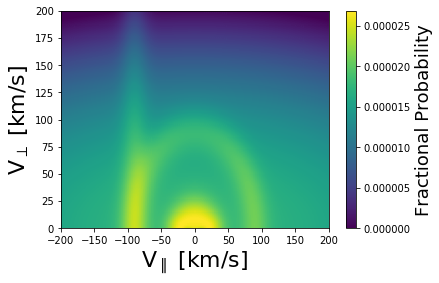

In [17]:
#Guess width
g_wid = 20 #km/s

#Initial guess around current guess of 2d VDF
pred_grid = np.log10(dis_vdf_bad_guess['vdf'])
good_vdf_values =  np.isfinite(pred_grid)
pred_grid[good_vdf_values == False] = np.min(pred_grid[good_vdf_values])
pred_grid -= np.min(pred_grid)
pred_grid /= np.sum(pred_grid)

#maximum value in VDF guess solution
max_pred_grid_norm = np.max(pred_grid)

#Initial guess based on ellipse near the kinematic values of the solar wind 
pred_grid += 0.5*max_pred_grid_norm*np.exp(- (dist/g_wid)**2.)


#Add a second component near 90 km/s
pred_grid += 0.2*max_pred_grid_norm*np.exp(- ((dis_vdf['pgrid']-(-90))/g_wid)**2.)

#Also add a band at a radius of 90 km/s
pred_grid += 0.2*max_pred_grid_norm*np.exp(- ((np.sqrt((dis_vdf['pgrid']**2+dis_vdf['qgrid']**2))-(90))/g_wid)**2.)

#get normalization factor
pred_grid /= np.sum(pred_grid)


print(np.min(pred_grid))
#default prediction grid to set back to if the function gets stuck
default_grid = pred_grid

fig, ax = plt.subplots()

plotc = ax.pcolormesh(dis_vdf_bad_guess['pgrid'],dis_vdf_bad_guess['qgrid'],pred_grid)
cbar = fig.colorbar(plotc)

cbar.set_label('Fractional Probability',fontsize=18)
ax.set_xlabel(r'V$_\parallel$ [km/s]',fontsize=22)
ax.set_ylabel(r'V$_\perp$ [km/s]',fontsize=22)
plt.show()

In [18]:
#Probability of selecting a gaussian that subtracts or adds to the vdf
n_p_prob = np.array([0.5,0.5])

#Inital bad sum squared error value
tot_err = 1e31 #a very large number
per_err = .10

#whether a given p, q value improved the fit
improved = False
ip,iq = 0.,0.



#counter tells the number of iterations to go before resetting the initial guess PDF
counter = 0
#Number of iterations before resetting
tol_cnt = 100
#kernel size for fitting
kernel = 20.*np.sqrt(2.)

In [19]:
#Loop until completion
looper = True

start_loop = time.time()
#removed to test improving fit
for i in range(6000):
    #error from previous iteration
    pre_err = per_err
    #get a new vdf and return if it is the best fit
    #dis_vdf_bad,tot_error,dis_cur = create_random_vdf(dis_vdf_bad,nproc,n_p_prob)
    #print(ip,iq,n_p_prob)
    fcs,tot_err,dis_vdf_bad,improved,ip,iq,n_p_prob = mff.create_random_vdf_multi_fc(fcs,nproc,tot_err,
                                                                            dis_vdf_bad,cont,pred_grid,
                                                                            kernel,
                                                                            improved=improved,ip=ip,
                                                                            iq=iq,n_p_prob=n_p_prob,
                                                                            sc_range=0.1,samp=samp)
    
    if improved:
        #scale probability by how large of a jump is made
        if tot_err > 1e30:
            scale = 0.1
        else:
            scale = (pre_err-tot_err)
            if scale < 0.:
                scale = 0.
        
        #calculate peak at ip,iq value using the percent error change
        a = 100.*(scale)/float(pred_grid.size)
        
        #Also add a band at a radius p,q values
        r_ipq = np.sqrt(ip**2+iq**2)
        #Add probability kernel at that location
        pred_grid += a*np.exp(- ((np.sqrt((dis_vdf_bad['pgrid']**2+dis_vdf_bad['qgrid']**2))-(r_ipq))/g_wid)**2.)
        #normalize to 1
        pred_grid /= np.sum(pred_grid)
        
        #Remove 10 guesses for counter for bad guesses
        counter -= 10
        #Do not let counter go below 0
        if counter < 0:
            counter = 0
    else:
        #increment the bad guess for the current model pdf
        counter += 1
        #reset the grid back to the default if there are too many bad guess with current pdf
        #do not probe velocity structures less than the measured spacing in the FC
        if ((counter > tol_cnt) & (kernel >= 15)):
            #reset the grid
            pred_grid = default_grid
            counter = 0
            if kernel >= 15.:
               #decrease the kernel size by 10%
               kernel *= 0.9
        print('Current Kerel Size',round(kernel*np.sqrt(2.)))
        
         
    per_err = tot_err

    print('Total error for iteration {0:1d} is {1:4.3e}%'.format(i,100.*float(tot_err)))

end_loop = time.time()
print('Loop time {0:1.1f}s'.format(end_loop-start_loop))

Total error for iteration 0 is 1.703e+01%
('Current Kerel Size', 40.0)
Total error for iteration 1 is 1.703e+01%
('Current Kerel Size', 40.0)
Total error for iteration 2 is 1.703e+01%
('Current Kerel Size', 40.0)
Total error for iteration 3 is 1.703e+01%
('Current Kerel Size', 40.0)
Total error for iteration 4 is 1.703e+01%
('Current Kerel Size', 40.0)
Total error for iteration 5 is 1.703e+01%
('Current Kerel Size', 40.0)
Total error for iteration 6 is 1.703e+01%
('Current Kerel Size', 40.0)
Total error for iteration 7 is 1.703e+01%
('Current Kerel Size', 40.0)
Total error for iteration 8 is 1.703e+01%
('Current Kerel Size', 40.0)
Total error for iteration 9 is 1.703e+01%
('Current Kerel Size', 40.0)
Total error for iteration 10 is 1.703e+01%
('Current Kerel Size', 40.0)
Total error for iteration 11 is 1.703e+01%
('Current Kerel Size', 40.0)
Total error for iteration 12 is 1.703e+01%
('Current Kerel Size', 40.0)
Total error for iteration 13 is 1.703e+01%
('Current Kerel Size', 40.0)
To

('Current Kerel Size', 40.0)
Total error for iteration 121 is 1.181e+01%
('Current Kerel Size', 40.0)
Total error for iteration 122 is 1.181e+01%
('Current Kerel Size', 40.0)
Total error for iteration 123 is 1.181e+01%
('Current Kerel Size', 40.0)
Total error for iteration 124 is 1.181e+01%
('Current Kerel Size', 40.0)
Total error for iteration 125 is 1.181e+01%
('Current Kerel Size', 40.0)
Total error for iteration 126 is 1.180e+01%
('Current Kerel Size', 40.0)
Total error for iteration 127 is 1.180e+01%
Total error for iteration 128 is 1.180e+01%
('Current Kerel Size', 40.0)
Total error for iteration 129 is 1.180e+01%
('Current Kerel Size', 40.0)
Total error for iteration 130 is 1.180e+01%
('Current Kerel Size', 40.0)
Total error for iteration 131 is 1.180e+01%
('Current Kerel Size', 40.0)
Total error for iteration 132 is 1.180e+01%
('Current Kerel Size', 40.0)
Total error for iteration 133 is 1.180e+01%
('Current Kerel Size', 40.0)
Total error for iteration 134 is 1.180e+01%
('Curre

('Current Kerel Size', 40.0)
Total error for iteration 243 is 1.113e+01%
('Current Kerel Size', 40.0)
Total error for iteration 244 is 1.113e+01%
('Current Kerel Size', 40.0)
Total error for iteration 245 is 1.113e+01%
('Current Kerel Size', 40.0)
Total error for iteration 246 is 1.113e+01%
('Current Kerel Size', 40.0)
Total error for iteration 247 is 1.113e+01%
('Current Kerel Size', 40.0)
Total error for iteration 248 is 1.113e+01%
('Current Kerel Size', 40.0)
Total error for iteration 249 is 1.113e+01%
('Current Kerel Size', 40.0)
Total error for iteration 250 is 1.113e+01%
('Current Kerel Size', 40.0)
Total error for iteration 251 is 1.113e+01%
Total error for iteration 252 is 1.111e+01%
('Current Kerel Size', 40.0)
Total error for iteration 253 is 1.111e+01%
('Current Kerel Size', 40.0)
Total error for iteration 254 is 1.111e+01%
('Current Kerel Size', 40.0)
Total error for iteration 255 is 1.111e+01%
('Current Kerel Size', 40.0)
Total error for iteration 256 is 1.111e+01%
('Curre

('Current Kerel Size', 40.0)
Total error for iteration 362 is 1.077e+01%
('Current Kerel Size', 40.0)
Total error for iteration 363 is 1.077e+01%
('Current Kerel Size', 40.0)
Total error for iteration 364 is 1.077e+01%
Total error for iteration 365 is 1.076e+01%
Total error for iteration 366 is 1.076e+01%
Total error for iteration 367 is 1.075e+01%
Total error for iteration 368 is 1.075e+01%
('Current Kerel Size', 40.0)
Total error for iteration 369 is 1.075e+01%
('Current Kerel Size', 40.0)
Total error for iteration 370 is 1.075e+01%
('Current Kerel Size', 40.0)
Total error for iteration 371 is 1.075e+01%
('Current Kerel Size', 40.0)
Total error for iteration 372 is 1.075e+01%
Total error for iteration 373 is 1.074e+01%
('Current Kerel Size', 40.0)
Total error for iteration 374 is 1.073e+01%
('Current Kerel Size', 40.0)
Total error for iteration 375 is 1.073e+01%
Total error for iteration 376 is 1.073e+01%
('Current Kerel Size', 40.0)
Total error for iteration 377 is 1.073e+01%
('Curr

('Current Kerel Size', 40.0)
Total error for iteration 478 is 1.072e+01%
('Current Kerel Size', 40.0)
Total error for iteration 479 is 1.072e+01%
('Current Kerel Size', 40.0)
Total error for iteration 480 is 1.072e+01%
('Current Kerel Size', 40.0)
Total error for iteration 481 is 1.072e+01%
('Current Kerel Size', 40.0)
Total error for iteration 482 is 1.072e+01%
('Current Kerel Size', 40.0)
Total error for iteration 483 is 1.072e+01%
('Current Kerel Size', 40.0)
Total error for iteration 484 is 1.072e+01%
('Current Kerel Size', 40.0)
Total error for iteration 485 is 1.072e+01%
('Current Kerel Size', 40.0)
Total error for iteration 486 is 1.072e+01%
Total error for iteration 487 is 1.072e+01%
Total error for iteration 488 is 1.072e+01%
('Current Kerel Size', 40.0)
Total error for iteration 489 is 1.072e+01%
('Current Kerel Size', 40.0)
Total error for iteration 490 is 1.072e+01%
('Current Kerel Size', 40.0)
Total error for iteration 491 is 1.072e+01%
('Current Kerel Size', 40.0)
Total e

('Current Kerel Size', 36.0)
Total error for iteration 597 is 1.065e+01%
('Current Kerel Size', 36.0)
Total error for iteration 598 is 1.065e+01%
('Current Kerel Size', 36.0)
Total error for iteration 599 is 1.065e+01%
('Current Kerel Size', 36.0)
Total error for iteration 600 is 1.065e+01%
('Current Kerel Size', 36.0)
Total error for iteration 601 is 1.065e+01%
Total error for iteration 602 is 1.064e+01%
('Current Kerel Size', 36.0)
Total error for iteration 603 is 1.064e+01%
('Current Kerel Size', 36.0)
Total error for iteration 604 is 1.064e+01%
('Current Kerel Size', 36.0)
Total error for iteration 605 is 1.064e+01%
Total error for iteration 606 is 1.064e+01%
('Current Kerel Size', 36.0)
Total error for iteration 607 is 1.064e+01%
('Current Kerel Size', 36.0)
Total error for iteration 608 is 1.064e+01%
('Current Kerel Size', 36.0)
Total error for iteration 609 is 1.064e+01%
('Current Kerel Size', 36.0)
Total error for iteration 610 is 1.064e+01%
('Current Kerel Size', 36.0)
Total e

('Current Kerel Size', 36.0)
Total error for iteration 716 is 1.051e+01%
('Current Kerel Size', 36.0)
Total error for iteration 717 is 1.051e+01%
Total error for iteration 718 is 1.051e+01%
('Current Kerel Size', 36.0)
Total error for iteration 719 is 1.051e+01%
('Current Kerel Size', 36.0)
Total error for iteration 720 is 1.051e+01%
('Current Kerel Size', 36.0)
Total error for iteration 721 is 1.051e+01%
('Current Kerel Size', 36.0)
Total error for iteration 722 is 1.051e+01%
('Current Kerel Size', 36.0)
Total error for iteration 723 is 1.051e+01%
('Current Kerel Size', 36.0)
Total error for iteration 724 is 1.051e+01%
('Current Kerel Size', 36.0)
Total error for iteration 725 is 1.051e+01%
('Current Kerel Size', 36.0)
Total error for iteration 726 is 1.051e+01%
('Current Kerel Size', 36.0)
Total error for iteration 727 is 1.051e+01%
('Current Kerel Size', 36.0)
Total error for iteration 728 is 1.051e+01%
('Current Kerel Size', 36.0)
Total error for iteration 729 is 1.051e+01%
('Curre

('Current Kerel Size', 36.0)
Total error for iteration 831 is 1.045e+01%
Total error for iteration 832 is 1.037e+01%
Total error for iteration 833 is 1.034e+01%
Total error for iteration 834 is 1.034e+01%
Total error for iteration 835 is 1.034e+01%
('Current Kerel Size', 36.0)
Total error for iteration 836 is 1.034e+01%
('Current Kerel Size', 36.0)
Total error for iteration 837 is 1.034e+01%
('Current Kerel Size', 36.0)
Total error for iteration 838 is 1.034e+01%
('Current Kerel Size', 36.0)
Total error for iteration 839 is 1.034e+01%
('Current Kerel Size', 36.0)
Total error for iteration 840 is 1.034e+01%
Total error for iteration 841 is 1.027e+01%
('Current Kerel Size', 36.0)
Total error for iteration 842 is 1.027e+01%
('Current Kerel Size', 36.0)
Total error for iteration 843 is 1.027e+01%
('Current Kerel Size', 36.0)
Total error for iteration 844 is 1.027e+01%
('Current Kerel Size', 36.0)
Total error for iteration 845 is 1.027e+01%
('Current Kerel Size', 36.0)
Total error for itera

('Current Kerel Size', 36.0)
Total error for iteration 953 is 1.016e+01%
('Current Kerel Size', 36.0)
Total error for iteration 954 is 1.016e+01%
('Current Kerel Size', 36.0)
Total error for iteration 955 is 1.016e+01%
('Current Kerel Size', 36.0)
Total error for iteration 956 is 1.016e+01%
('Current Kerel Size', 36.0)
Total error for iteration 957 is 1.016e+01%
('Current Kerel Size', 36.0)
Total error for iteration 958 is 1.016e+01%
('Current Kerel Size', 36.0)
Total error for iteration 959 is 1.016e+01%
('Current Kerel Size', 36.0)
Total error for iteration 960 is 1.016e+01%
('Current Kerel Size', 36.0)
Total error for iteration 961 is 1.016e+01%
('Current Kerel Size', 36.0)
Total error for iteration 962 is 1.016e+01%
('Current Kerel Size', 36.0)
Total error for iteration 963 is 1.016e+01%
('Current Kerel Size', 36.0)
Total error for iteration 964 is 1.016e+01%
('Current Kerel Size', 36.0)
Total error for iteration 965 is 1.016e+01%
('Current Kerel Size', 36.0)
Total error for iterat

('Current Kerel Size', 36.0)
Total error for iteration 1066 is 1.015e+01%
('Current Kerel Size', 36.0)
Total error for iteration 1067 is 1.015e+01%
('Current Kerel Size', 36.0)
Total error for iteration 1068 is 1.015e+01%
('Current Kerel Size', 36.0)
Total error for iteration 1069 is 1.015e+01%
('Current Kerel Size', 36.0)
Total error for iteration 1070 is 1.015e+01%
('Current Kerel Size', 36.0)
Total error for iteration 1071 is 1.015e+01%
('Current Kerel Size', 36.0)
Total error for iteration 1072 is 1.015e+01%
('Current Kerel Size', 36.0)
Total error for iteration 1073 is 1.015e+01%
('Current Kerel Size', 36.0)
Total error for iteration 1074 is 1.015e+01%
('Current Kerel Size', 36.0)
Total error for iteration 1075 is 1.015e+01%
('Current Kerel Size', 32.0)
Total error for iteration 1076 is 1.015e+01%
('Current Kerel Size', 32.0)
Total error for iteration 1077 is 1.015e+01%
('Current Kerel Size', 32.0)
Total error for iteration 1078 is 1.015e+01%
('Current Kerel Size', 32.0)
Total err

('Current Kerel Size', 32.0)
Total error for iteration 1179 is 9.708e+00%
('Current Kerel Size', 32.0)
Total error for iteration 1180 is 9.708e+00%
Total error for iteration 1181 is 9.703e+00%
('Current Kerel Size', 32.0)
Total error for iteration 1182 is 9.703e+00%
('Current Kerel Size', 32.0)
Total error for iteration 1183 is 9.703e+00%
('Current Kerel Size', 32.0)
Total error for iteration 1184 is 9.703e+00%
Total error for iteration 1185 is 9.701e+00%
Total error for iteration 1186 is 9.699e+00%
Total error for iteration 1187 is 9.694e+00%
Total error for iteration 1188 is 9.693e+00%
Total error for iteration 1189 is 9.691e+00%
Total error for iteration 1190 is 9.690e+00%
Total error for iteration 1191 is 9.687e+00%
('Current Kerel Size', 32.0)
Total error for iteration 1192 is 9.686e+00%
('Current Kerel Size', 32.0)
Total error for iteration 1193 is 9.686e+00%
('Current Kerel Size', 32.0)
Total error for iteration 1194 is 9.686e+00%
('Current Kerel Size', 32.0)
Total error for ite

('Current Kerel Size', 32.0)
Total error for iteration 1299 is 9.620e+00%
('Current Kerel Size', 32.0)
Total error for iteration 1300 is 9.620e+00%
('Current Kerel Size', 32.0)
Total error for iteration 1301 is 9.620e+00%
('Current Kerel Size', 32.0)
Total error for iteration 1302 is 9.620e+00%
('Current Kerel Size', 32.0)
Total error for iteration 1303 is 9.620e+00%
('Current Kerel Size', 32.0)
Total error for iteration 1304 is 9.620e+00%
('Current Kerel Size', 32.0)
Total error for iteration 1305 is 9.620e+00%
('Current Kerel Size', 32.0)
Total error for iteration 1306 is 9.619e+00%
('Current Kerel Size', 32.0)
Total error for iteration 1307 is 9.619e+00%
Total error for iteration 1308 is 9.595e+00%
('Current Kerel Size', 32.0)
Total error for iteration 1309 is 9.595e+00%
('Current Kerel Size', 32.0)
Total error for iteration 1310 is 9.595e+00%
('Current Kerel Size', 32.0)
Total error for iteration 1311 is 9.595e+00%
('Current Kerel Size', 32.0)
Total error for iteration 1312 is 9.59

('Current Kerel Size', 29.0)
Total error for iteration 1411 is 9.591e+00%
('Current Kerel Size', 29.0)
Total error for iteration 1412 is 9.591e+00%
('Current Kerel Size', 29.0)
Total error for iteration 1413 is 9.591e+00%
('Current Kerel Size', 29.0)
Total error for iteration 1414 is 9.591e+00%
('Current Kerel Size', 29.0)
Total error for iteration 1415 is 9.591e+00%
('Current Kerel Size', 29.0)
Total error for iteration 1416 is 9.591e+00%
('Current Kerel Size', 29.0)
Total error for iteration 1417 is 9.591e+00%
('Current Kerel Size', 29.0)
Total error for iteration 1418 is 9.591e+00%
('Current Kerel Size', 29.0)
Total error for iteration 1419 is 9.591e+00%
('Current Kerel Size', 29.0)
Total error for iteration 1420 is 9.591e+00%
('Current Kerel Size', 29.0)
Total error for iteration 1421 is 9.591e+00%
('Current Kerel Size', 29.0)
Total error for iteration 1422 is 9.591e+00%
('Current Kerel Size', 29.0)
Total error for iteration 1423 is 9.591e+00%
('Current Kerel Size', 29.0)
Total err

('Current Kerel Size', 29.0)
Total error for iteration 1525 is 9.564e+00%
('Current Kerel Size', 29.0)
Total error for iteration 1526 is 9.564e+00%
('Current Kerel Size', 29.0)
Total error for iteration 1527 is 9.563e+00%
('Current Kerel Size', 29.0)
Total error for iteration 1528 is 9.563e+00%
('Current Kerel Size', 29.0)
Total error for iteration 1529 is 9.563e+00%
('Current Kerel Size', 29.0)
Total error for iteration 1530 is 9.563e+00%
('Current Kerel Size', 29.0)
Total error for iteration 1531 is 9.563e+00%
('Current Kerel Size', 29.0)
Total error for iteration 1532 is 9.563e+00%
('Current Kerel Size', 29.0)
Total error for iteration 1533 is 9.563e+00%
('Current Kerel Size', 29.0)
Total error for iteration 1534 is 9.563e+00%
('Current Kerel Size', 29.0)
Total error for iteration 1535 is 9.563e+00%
('Current Kerel Size', 29.0)
Total error for iteration 1536 is 9.563e+00%
('Current Kerel Size', 29.0)
Total error for iteration 1537 is 9.563e+00%
('Current Kerel Size', 29.0)
Total err

('Current Kerel Size', 26.0)
Total error for iteration 1637 is 9.530e+00%
('Current Kerel Size', 26.0)
Total error for iteration 1638 is 9.530e+00%
('Current Kerel Size', 26.0)
Total error for iteration 1639 is 9.530e+00%
('Current Kerel Size', 26.0)
Total error for iteration 1640 is 9.530e+00%
('Current Kerel Size', 26.0)
Total error for iteration 1641 is 9.530e+00%
('Current Kerel Size', 26.0)
Total error for iteration 1642 is 9.530e+00%
('Current Kerel Size', 26.0)
Total error for iteration 1643 is 9.530e+00%
('Current Kerel Size', 26.0)
Total error for iteration 1644 is 9.530e+00%
('Current Kerel Size', 26.0)
Total error for iteration 1645 is 9.530e+00%
('Current Kerel Size', 26.0)
Total error for iteration 1646 is 9.530e+00%
('Current Kerel Size', 26.0)
Total error for iteration 1647 is 9.530e+00%
('Current Kerel Size', 26.0)
Total error for iteration 1648 is 9.530e+00%
Total error for iteration 1649 is 9.527e+00%
Total error for iteration 1650 is 9.525e+00%
Total error for iterat

('Current Kerel Size', 26.0)
Total error for iteration 1751 is 9.508e+00%
('Current Kerel Size', 26.0)
Total error for iteration 1752 is 9.508e+00%
('Current Kerel Size', 26.0)
Total error for iteration 1753 is 9.508e+00%
('Current Kerel Size', 26.0)
Total error for iteration 1754 is 9.508e+00%
('Current Kerel Size', 26.0)
Total error for iteration 1755 is 9.508e+00%
('Current Kerel Size', 26.0)
Total error for iteration 1756 is 9.508e+00%
('Current Kerel Size', 26.0)
Total error for iteration 1757 is 9.508e+00%
('Current Kerel Size', 26.0)
Total error for iteration 1758 is 9.508e+00%
('Current Kerel Size', 26.0)
Total error for iteration 1759 is 9.508e+00%
('Current Kerel Size', 26.0)
Total error for iteration 1760 is 9.508e+00%
('Current Kerel Size', 26.0)
Total error for iteration 1761 is 9.508e+00%
('Current Kerel Size', 26.0)
Total error for iteration 1762 is 9.508e+00%
('Current Kerel Size', 26.0)
Total error for iteration 1763 is 9.508e+00%
('Current Kerel Size', 24.0)
Total err

('Current Kerel Size', 24.0)
Total error for iteration 1868 is 9.052e+00%
('Current Kerel Size', 24.0)
Total error for iteration 1869 is 9.052e+00%
Total error for iteration 1870 is 9.050e+00%
('Current Kerel Size', 24.0)
Total error for iteration 1871 is 9.050e+00%
('Current Kerel Size', 24.0)
Total error for iteration 1872 is 9.049e+00%
('Current Kerel Size', 24.0)
Total error for iteration 1873 is 9.049e+00%
('Current Kerel Size', 24.0)
Total error for iteration 1874 is 9.049e+00%
Total error for iteration 1875 is 9.047e+00%
('Current Kerel Size', 24.0)
Total error for iteration 1876 is 9.047e+00%
('Current Kerel Size', 24.0)
Total error for iteration 1877 is 9.047e+00%
('Current Kerel Size', 24.0)
Total error for iteration 1878 is 9.047e+00%
('Current Kerel Size', 24.0)
Total error for iteration 1879 is 9.047e+00%
('Current Kerel Size', 24.0)
Total error for iteration 1880 is 9.047e+00%
Total error for iteration 1881 is 9.045e+00%
('Current Kerel Size', 24.0)
Total error for iterat

('Current Kerel Size', 24.0)
Total error for iteration 1984 is 8.957e+00%
('Current Kerel Size', 24.0)
Total error for iteration 1985 is 8.957e+00%
('Current Kerel Size', 24.0)
Total error for iteration 1986 is 8.957e+00%
('Current Kerel Size', 24.0)
Total error for iteration 1987 is 8.957e+00%
('Current Kerel Size', 24.0)
Total error for iteration 1988 is 8.957e+00%
('Current Kerel Size', 24.0)
Total error for iteration 1989 is 8.957e+00%
('Current Kerel Size', 24.0)
Total error for iteration 1990 is 8.957e+00%
('Current Kerel Size', 24.0)
Total error for iteration 1991 is 8.957e+00%
('Current Kerel Size', 24.0)
Total error for iteration 1992 is 8.957e+00%
('Current Kerel Size', 24.0)
Total error for iteration 1993 is 8.957e+00%
('Current Kerel Size', 24.0)
Total error for iteration 1994 is 8.957e+00%
('Current Kerel Size', 24.0)
Total error for iteration 1995 is 8.957e+00%
('Current Kerel Size', 24.0)
Total error for iteration 1996 is 8.957e+00%
('Current Kerel Size', 24.0)
Total err

('Current Kerel Size', 24.0)
Total error for iteration 2098 is 8.839e+00%
('Current Kerel Size', 24.0)
Total error for iteration 2099 is 8.839e+00%
('Current Kerel Size', 24.0)
Total error for iteration 2100 is 8.839e+00%
('Current Kerel Size', 24.0)
Total error for iteration 2101 is 8.839e+00%
('Current Kerel Size', 24.0)
Total error for iteration 2102 is 8.839e+00%
('Current Kerel Size', 24.0)
Total error for iteration 2103 is 8.839e+00%
('Current Kerel Size', 24.0)
Total error for iteration 2104 is 8.839e+00%
('Current Kerel Size', 24.0)
Total error for iteration 2105 is 8.839e+00%
('Current Kerel Size', 24.0)
Total error for iteration 2106 is 8.839e+00%
Total error for iteration 2107 is 8.837e+00%
('Current Kerel Size', 24.0)
Total error for iteration 2108 is 8.837e+00%
('Current Kerel Size', 24.0)
Total error for iteration 2109 is 8.837e+00%
('Current Kerel Size', 24.0)
Total error for iteration 2110 is 8.837e+00%
('Current Kerel Size', 24.0)
Total error for iteration 2111 is 8.83

('Current Kerel Size', 21.0)
Total error for iteration 2212 is 8.809e+00%
('Current Kerel Size', 21.0)
Total error for iteration 2213 is 8.809e+00%
('Current Kerel Size', 21.0)
Total error for iteration 2214 is 8.809e+00%
('Current Kerel Size', 21.0)
Total error for iteration 2215 is 8.809e+00%
('Current Kerel Size', 21.0)
Total error for iteration 2216 is 8.809e+00%
('Current Kerel Size', 21.0)
Total error for iteration 2217 is 8.809e+00%
Total error for iteration 2218 is 8.806e+00%
('Current Kerel Size', 21.0)
Total error for iteration 2219 is 8.806e+00%
('Current Kerel Size', 21.0)
Total error for iteration 2220 is 8.806e+00%
('Current Kerel Size', 21.0)
Total error for iteration 2221 is 8.806e+00%
('Current Kerel Size', 21.0)
Total error for iteration 2222 is 8.806e+00%
('Current Kerel Size', 21.0)
Total error for iteration 2223 is 8.806e+00%
('Current Kerel Size', 21.0)
Total error for iteration 2224 is 8.806e+00%
Total error for iteration 2225 is 8.804e+00%
Total error for iterat

('Current Kerel Size', 21.0)
Total error for iteration 2329 is 8.723e+00%
('Current Kerel Size', 21.0)
Total error for iteration 2330 is 8.723e+00%
('Current Kerel Size', 21.0)
Total error for iteration 2331 is 8.723e+00%
('Current Kerel Size', 21.0)
Total error for iteration 2332 is 8.723e+00%
('Current Kerel Size', 21.0)
Total error for iteration 2333 is 8.723e+00%
('Current Kerel Size', 21.0)
Total error for iteration 2334 is 8.723e+00%
('Current Kerel Size', 21.0)
Total error for iteration 2335 is 8.723e+00%
('Current Kerel Size', 21.0)
Total error for iteration 2336 is 8.723e+00%
('Current Kerel Size', 21.0)
Total error for iteration 2337 is 8.723e+00%
('Current Kerel Size', 21.0)
Total error for iteration 2338 is 8.723e+00%
('Current Kerel Size', 21.0)
Total error for iteration 2339 is 8.723e+00%
('Current Kerel Size', 21.0)
Total error for iteration 2340 is 8.723e+00%
('Current Kerel Size', 21.0)
Total error for iteration 2341 is 8.723e+00%
('Current Kerel Size', 21.0)
Total err

('Current Kerel Size', 21.0)
Total error for iteration 2444 is 8.593e+00%
('Current Kerel Size', 21.0)
Total error for iteration 2445 is 8.593e+00%
('Current Kerel Size', 21.0)
Total error for iteration 2446 is 8.593e+00%
('Current Kerel Size', 21.0)
Total error for iteration 2447 is 8.593e+00%
('Current Kerel Size', 21.0)
Total error for iteration 2448 is 8.593e+00%
('Current Kerel Size', 21.0)
Total error for iteration 2449 is 8.593e+00%
('Current Kerel Size', 21.0)
Total error for iteration 2450 is 8.593e+00%
('Current Kerel Size', 21.0)
Total error for iteration 2451 is 8.593e+00%
('Current Kerel Size', 21.0)
Total error for iteration 2452 is 8.593e+00%
Total error for iteration 2453 is 8.592e+00%
('Current Kerel Size', 21.0)
Total error for iteration 2454 is 8.592e+00%
('Current Kerel Size', 21.0)
Total error for iteration 2455 is 8.592e+00%
('Current Kerel Size', 21.0)
Total error for iteration 2456 is 8.592e+00%
('Current Kerel Size', 21.0)
Total error for iteration 2457 is 8.59

('Current Kerel Size', 19.0)
Total error for iteration 2558 is 8.577e+00%
Total error for iteration 2559 is 8.576e+00%
Total error for iteration 2560 is 8.572e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2561 is 8.572e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2562 is 8.572e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2563 is 8.572e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2564 is 8.572e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2565 is 8.572e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2566 is 8.572e+00%
Total error for iteration 2567 is 8.560e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2568 is 8.560e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2569 is 8.560e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2570 is 8.560e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2571 is 8.560e+00%
('Current Kerel Size', 19.0)
Total error for iterat

Total error for iteration 2671 is 8.549e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2672 is 8.549e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2673 is 8.549e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2674 is 8.549e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2675 is 8.549e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2676 is 8.549e+00%
Total error for iteration 2677 is 8.548e+00%
Total error for iteration 2678 is 8.547e+00%
Total error for iteration 2679 is 8.545e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2680 is 8.545e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2681 is 8.545e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2682 is 8.545e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2683 is 8.545e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2684 is 8.545e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2685 is 8.544e+00%
('Curr

('Current Kerel Size', 19.0)
Total error for iteration 2785 is 8.526e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2786 is 8.526e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2787 is 8.526e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2788 is 8.526e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2789 is 8.526e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2790 is 8.526e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2791 is 8.526e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2792 is 8.526e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2793 is 8.526e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2794 is 8.526e+00%
Total error for iteration 2795 is 8.525e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2796 is 8.524e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2797 is 8.524e+00%
Total error for iteration 2798 is 8.523e+00%
Total error for iterat

Total error for iteration 2899 is 8.509e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2900 is 8.509e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2901 is 8.509e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2902 is 8.509e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2903 is 8.509e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2904 is 8.509e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2905 is 8.509e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2906 is 8.509e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2907 is 8.509e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2908 is 8.509e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2909 is 8.509e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2910 is 8.509e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2911 is 8.509e+00%
('Current Kerel Size', 19.0)
Total error for iteration 2912 is 8.50

('Current Kerel Size', 19.0)
Total error for iteration 3011 is 8.506e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3012 is 8.506e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3013 is 8.506e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3014 is 8.506e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3015 is 8.506e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3016 is 8.506e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3017 is 8.506e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3018 is 8.506e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3019 is 8.505e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3020 is 8.505e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3021 is 8.505e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3022 is 8.505e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3023 is 8.505e+00%
('Current Kerel Size', 19.0)
Total err

('Current Kerel Size', 19.0)
Total error for iteration 3123 is 8.492e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3124 is 8.492e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3125 is 8.492e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3126 is 8.492e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3127 is 8.492e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3128 is 8.492e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3129 is 8.492e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3130 is 8.492e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3131 is 8.492e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3132 is 8.492e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3133 is 8.492e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3134 is 8.492e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3135 is 8.492e+00%
('Current Kerel Size', 19.0)
Total err

('Current Kerel Size', 19.0)
Total error for iteration 3235 is 8.490e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3236 is 8.490e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3237 is 8.490e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3238 is 8.490e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3239 is 8.490e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3240 is 8.490e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3241 is 8.489e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3242 is 8.489e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3243 is 8.489e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3244 is 8.489e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3245 is 8.489e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3246 is 8.489e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3247 is 8.489e+00%
('Current Kerel Size', 19.0)
Total err

('Current Kerel Size', 19.0)
Total error for iteration 3346 is 8.488e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3347 is 8.488e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3348 is 8.488e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3349 is 8.488e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3350 is 8.488e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3351 is 8.488e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3352 is 8.488e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3353 is 8.488e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3354 is 8.488e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3355 is 8.488e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3356 is 8.488e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3357 is 8.488e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3358 is 8.488e+00%
('Current Kerel Size', 19.0)
Total err

('Current Kerel Size', 19.0)
Total error for iteration 3458 is 8.485e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3459 is 8.485e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3460 is 8.485e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3461 is 8.485e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3462 is 8.485e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3463 is 8.485e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3464 is 8.485e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3465 is 8.485e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3466 is 8.485e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3467 is 8.485e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3468 is 8.485e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3469 is 8.485e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3470 is 8.485e+00%
('Current Kerel Size', 19.0)
Total err

('Current Kerel Size', 19.0)
Total error for iteration 3570 is 8.483e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3571 is 8.483e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3572 is 8.483e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3573 is 8.483e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3574 is 8.483e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3575 is 8.483e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3576 is 8.483e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3577 is 8.483e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3578 is 8.483e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3579 is 8.483e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3580 is 8.483e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3581 is 8.483e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3582 is 8.483e+00%
('Current Kerel Size', 19.0)
Total err

('Current Kerel Size', 19.0)
Total error for iteration 3682 is 8.470e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3683 is 8.470e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3684 is 8.470e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3685 is 8.470e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3686 is 8.470e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3687 is 8.470e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3688 is 8.470e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3689 is 8.470e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3690 is 8.470e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3691 is 8.470e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3692 is 8.470e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3693 is 8.470e+00%
Total error for iteration 3694 is 8.465e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3695 is 8.46

('Current Kerel Size', 19.0)
Total error for iteration 3794 is 8.462e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3795 is 8.462e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3796 is 8.462e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3797 is 8.462e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3798 is 8.462e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3799 is 8.462e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3800 is 8.462e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3801 is 8.462e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3802 is 8.462e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3803 is 8.462e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3804 is 8.462e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3805 is 8.462e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3806 is 8.462e+00%
('Current Kerel Size', 19.0)
Total err

('Current Kerel Size', 19.0)
Total error for iteration 3906 is 8.459e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3907 is 8.459e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3908 is 8.459e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3909 is 8.459e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3910 is 8.459e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3911 is 8.459e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3912 is 8.459e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3913 is 8.459e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3914 is 8.459e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3915 is 8.459e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3916 is 8.459e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3917 is 8.459e+00%
('Current Kerel Size', 19.0)
Total error for iteration 3918 is 8.459e+00%
('Current Kerel Size', 19.0)
Total err

('Current Kerel Size', 19.0)
Total error for iteration 4017 is 8.458e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4018 is 8.458e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4019 is 8.458e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4020 is 8.458e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4021 is 8.458e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4022 is 8.457e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4023 is 8.457e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4024 is 8.457e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4025 is 8.457e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4026 is 8.457e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4027 is 8.457e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4028 is 8.457e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4029 is 8.457e+00%
('Current Kerel Size', 19.0)
Total err

('Current Kerel Size', 19.0)
Total error for iteration 4128 is 8.454e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4129 is 8.454e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4130 is 8.454e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4131 is 8.454e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4132 is 8.454e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4133 is 8.454e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4134 is 8.454e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4135 is 8.454e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4136 is 8.454e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4137 is 8.454e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4138 is 8.454e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4139 is 8.454e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4140 is 8.454e+00%
('Current Kerel Size', 19.0)
Total err

('Current Kerel Size', 19.0)
Total error for iteration 4239 is 8.452e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4240 is 8.452e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4241 is 8.452e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4242 is 8.452e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4243 is 8.452e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4244 is 8.452e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4245 is 8.452e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4246 is 8.452e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4247 is 8.452e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4248 is 8.452e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4249 is 8.452e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4250 is 8.452e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4251 is 8.452e+00%
('Current Kerel Size', 19.0)
Total err

('Current Kerel Size', 19.0)
Total error for iteration 4350 is 8.451e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4351 is 8.451e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4352 is 8.451e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4353 is 8.451e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4354 is 8.451e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4355 is 8.451e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4356 is 8.451e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4357 is 8.451e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4358 is 8.451e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4359 is 8.451e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4360 is 8.451e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4361 is 8.451e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4362 is 8.451e+00%
('Current Kerel Size', 19.0)
Total err

('Current Kerel Size', 19.0)
Total error for iteration 4461 is 8.450e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4462 is 8.450e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4463 is 8.450e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4464 is 8.450e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4465 is 8.450e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4466 is 8.450e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4467 is 8.450e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4468 is 8.450e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4469 is 8.450e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4470 is 8.450e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4471 is 8.450e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4472 is 8.450e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4473 is 8.450e+00%
('Current Kerel Size', 19.0)
Total err

('Current Kerel Size', 19.0)
Total error for iteration 4573 is 8.447e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4574 is 8.447e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4575 is 8.447e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4576 is 8.447e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4577 is 8.447e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4578 is 8.447e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4579 is 8.447e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4580 is 8.447e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4581 is 8.447e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4582 is 8.447e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4583 is 8.447e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4584 is 8.447e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4585 is 8.447e+00%
('Current Kerel Size', 19.0)
Total err

('Current Kerel Size', 19.0)
Total error for iteration 4684 is 8.446e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4685 is 8.446e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4686 is 8.446e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4687 is 8.446e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4688 is 8.446e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4689 is 8.446e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4690 is 8.446e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4691 is 8.446e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4692 is 8.446e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4693 is 8.446e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4694 is 8.446e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4695 is 8.446e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4696 is 8.446e+00%
('Current Kerel Size', 19.0)
Total err

('Current Kerel Size', 19.0)
Total error for iteration 4795 is 8.445e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4796 is 8.445e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4797 is 8.445e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4798 is 8.445e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4799 is 8.445e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4800 is 8.445e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4801 is 8.445e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4802 is 8.445e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4803 is 8.445e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4804 is 8.445e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4805 is 8.445e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4806 is 8.445e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4807 is 8.445e+00%
('Current Kerel Size', 19.0)
Total err

('Current Kerel Size', 19.0)
Total error for iteration 4906 is 8.445e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4907 is 8.445e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4908 is 8.445e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4909 is 8.445e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4910 is 8.445e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4911 is 8.445e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4912 is 8.445e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4913 is 8.445e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4914 is 8.445e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4915 is 8.445e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4916 is 8.445e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4917 is 8.445e+00%
('Current Kerel Size', 19.0)
Total error for iteration 4918 is 8.445e+00%
('Current Kerel Size', 19.0)
Total err

('Current Kerel Size', 19.0)
Total error for iteration 5017 is 8.444e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5018 is 8.444e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5019 is 8.444e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5020 is 8.444e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5021 is 8.444e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5022 is 8.444e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5023 is 8.444e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5024 is 8.444e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5025 is 8.444e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5026 is 8.444e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5027 is 8.443e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5028 is 8.443e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5029 is 8.443e+00%
('Current Kerel Size', 19.0)
Total err

('Current Kerel Size', 19.0)
Total error for iteration 5128 is 8.442e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5129 is 8.442e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5130 is 8.442e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5131 is 8.442e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5132 is 8.442e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5133 is 8.442e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5134 is 8.442e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5135 is 8.442e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5136 is 8.442e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5137 is 8.442e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5138 is 8.442e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5139 is 8.442e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5140 is 8.442e+00%
('Current Kerel Size', 19.0)
Total err

('Current Kerel Size', 19.0)
Total error for iteration 5239 is 8.440e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5240 is 8.440e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5241 is 8.440e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5242 is 8.440e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5243 is 8.440e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5244 is 8.440e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5245 is 8.440e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5246 is 8.440e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5247 is 8.440e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5248 is 8.440e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5249 is 8.440e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5250 is 8.440e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5251 is 8.440e+00%
('Current Kerel Size', 19.0)
Total err

('Current Kerel Size', 19.0)
Total error for iteration 5350 is 8.439e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5351 is 8.439e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5352 is 8.439e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5353 is 8.439e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5354 is 8.439e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5355 is 8.439e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5356 is 8.439e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5357 is 8.439e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5358 is 8.439e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5359 is 8.439e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5360 is 8.439e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5361 is 8.439e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5362 is 8.439e+00%
('Current Kerel Size', 19.0)
Total err

('Current Kerel Size', 19.0)
Total error for iteration 5461 is 8.438e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5462 is 8.438e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5463 is 8.438e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5464 is 8.438e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5465 is 8.438e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5466 is 8.438e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5467 is 8.438e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5468 is 8.438e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5469 is 8.438e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5470 is 8.438e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5471 is 8.438e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5472 is 8.438e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5473 is 8.438e+00%
('Current Kerel Size', 19.0)
Total err

('Current Kerel Size', 19.0)
Total error for iteration 5572 is 8.438e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5573 is 8.438e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5574 is 8.438e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5575 is 8.438e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5576 is 8.438e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5577 is 8.438e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5578 is 8.438e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5579 is 8.438e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5580 is 8.438e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5581 is 8.438e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5582 is 8.438e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5583 is 8.438e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5584 is 8.438e+00%
('Current Kerel Size', 19.0)
Total err

('Current Kerel Size', 19.0)
Total error for iteration 5683 is 8.438e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5684 is 8.438e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5685 is 8.438e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5686 is 8.438e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5687 is 8.438e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5688 is 8.438e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5689 is 8.438e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5690 is 8.438e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5691 is 8.438e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5692 is 8.437e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5693 is 8.437e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5694 is 8.437e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5695 is 8.437e+00%
('Current Kerel Size', 19.0)
Total err

('Current Kerel Size', 19.0)
Total error for iteration 5795 is 8.430e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5796 is 8.430e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5797 is 8.430e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5798 is 8.430e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5799 is 8.430e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5800 is 8.430e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5801 is 8.430e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5802 is 8.430e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5803 is 8.430e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5804 is 8.430e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5805 is 8.430e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5806 is 8.430e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5807 is 8.430e+00%
('Current Kerel Size', 19.0)
Total err

('Current Kerel Size', 19.0)
Total error for iteration 5907 is 8.427e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5908 is 8.427e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5909 is 8.427e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5910 is 8.427e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5911 is 8.427e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5912 is 8.427e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5913 is 8.427e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5914 is 8.427e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5915 is 8.427e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5916 is 8.427e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5917 is 8.427e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5918 is 8.427e+00%
('Current Kerel Size', 19.0)
Total error for iteration 5919 is 8.427e+00%
('Current Kerel Size', 19.0)
Total err

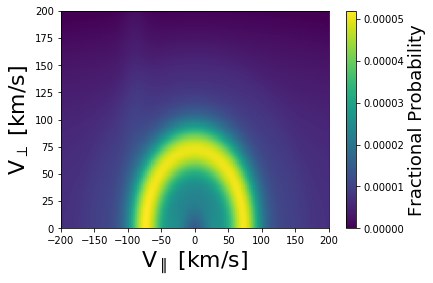

In [20]:
#Show prediction grid 
fig, ax = plt.subplots()

plotc = ax.pcolormesh(dis_vdf_bad_guess['pgrid'],dis_vdf_bad_guess['qgrid'],pred_grid)
cbar = fig.colorbar(plotc)

cbar.set_label('Fractional Probability',fontsize=18)
ax.set_xlabel(r'V$_\parallel$ [km/s]',fontsize=22)
ax.set_ylabel(r'V$_\perp$ [km/s]',fontsize=22)
plt.show()

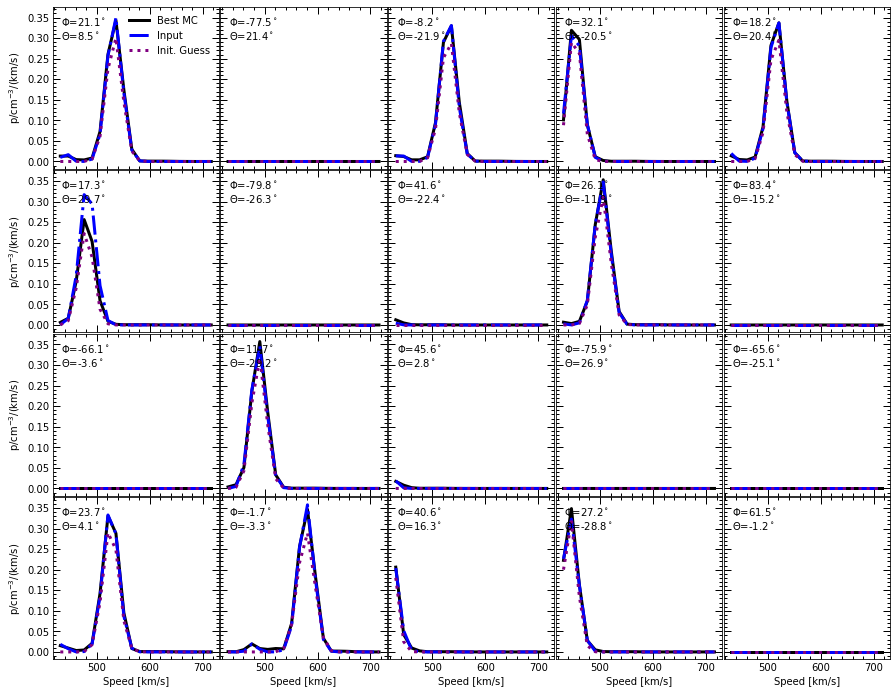

In [21]:
#Grid of FC guesses
mff.create_fc_grid_plot(fcs)
plt.show()

make_discrete_vdf.py:575: RuntimeWarning: divide by zero encountered in log10
  plotc = ax.pcolormesh(dis_vdf['pgrid'],dis_vdf['qgrid'],np.log10(dis_vdf['vdf']),vmin=-19,vmax=-5)
make_discrete_vdf.py:576: RuntimeWarning: divide by zero encountered in log10
  ax.contour(dis_vdf['pgrid'],dis_vdf['qgrid'],np.log10(dis_vdf['vdf']), contour_levels,colors='black',linestyles='dashed',linewidths=3 )


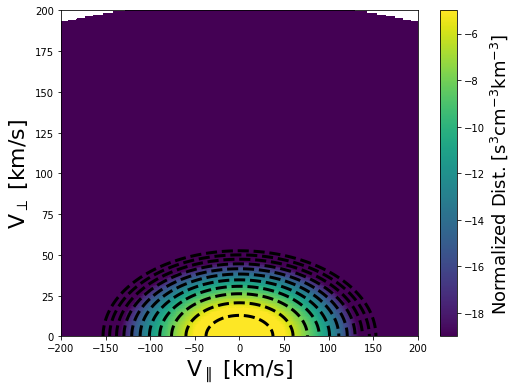

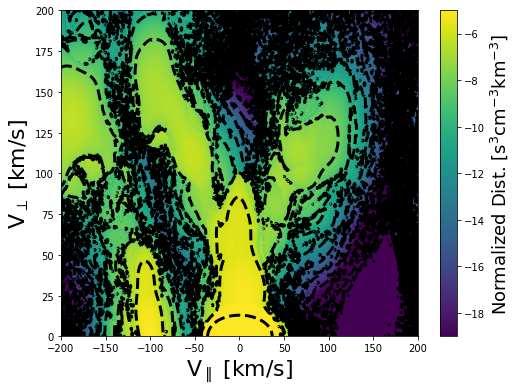

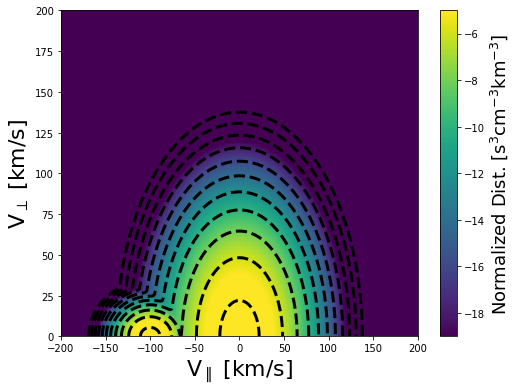

In [22]:
#Initial Guess from measurements
mdv.plot_vdf(dis_vdf_bad_guess)

#Best Fit MC VDF
mdv.plot_vdf(dis_vdf_bad)

#"REAL" OBSERVATION
mdv.plot_vdf(dis_vdf)

plt.show()